In [1]:
!pip install -Uq datasets fire

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import os
os.environ["TRANSFORMERS_VERBOSITY"]="error"

import torch
import random
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import (
    PaliGemmaProcessor,
    PaliGemmaForConditionalGeneration,
)
from functools import partial
from fire import Fire
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
def collate_fn(examples, processor):
    images = list()
    prompt = list()
    suffix = list()
    for sample in examples:
        images.append(sample["image"].convert("RGB"))
        suffix.append(str(sample["label"]))
        prompt.append("count intersection")

    inputs = processor(
        images=images,
        text=prompt,
        suffix=suffix,
        return_tensors="pt",
    )
    inputs = inputs.to(torch.bfloat16)
    return inputs

def freeze_layers(model):
    for name, param in model.named_parameters():
        if "attn" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    return model

def run_inference(val_dataset, processor, model):
    # infer before training
    val_sample = random.choice(val_dataset)
    image = val_sample["image"].convert("RGB")
    inputs = processor(
        images = [image],
        text = ["count intersection"],
        return_tensors="pt",
    ).to(torch.bfloat16)
    input_len = inputs["input_ids"].shape[-1]
    with torch.no_grad():
        generation = model.generate(**inputs.to(model.device), max_new_tokens=10)
        generation = generation[0][input_len:]
        decoded = processor.decode(generation, skip_special_tokens=True)

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {decoded}")
    plt.show()

def main(ckpt_id: str = "google/paligemma2-3b-pt-224", dataset_folder: str = "dataset"):
    # load the dataset and the processor
    print(f"[INFO] Loading {ckpt_id} processor")
    processor = PaliGemmaProcessor.from_pretrained(ckpt_id)

    # load the dataset
    print(f"[INFO] Loading {dataset_folder} dataset")
    train_dataset = load_dataset(dataset_folder, split="train")
    val_dataset = load_dataset(dataset_folder, split="validation")

    # create data loader
    print(f"[INFO] Creating dataloader")
    partial_collate_fn = partial(collate_fn, processor=processor)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=True,
        num_workers=2,
        drop_last=True,
        collate_fn=partial_collate_fn,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=2,
        shuffle=True,
        num_workers=2,
        drop_last=True,
        collate_fn=partial_collate_fn,
    )

    # load the model and optimizer
    print(f"[INFO] Loading {ckpt_id} model")
    model = PaliGemmaForConditionalGeneration.from_pretrained(
        ckpt_id, torch_dtype=torch.bfloat16, device_map="auto"
    )

    # run inference before training
    run_inference(val_dataset, processor, model)

    model = freeze_layers(model)
    print(f"[INFO] Model loaded on {model.device}")
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-5,
    )

    # Start Training
    accumulation_steps = 8
    for idx, batch in tqdm(enumerate(train_dataloader)):
        outputs = model(**batch.to(model.device))
        loss = outputs.loss / accumulation_steps
        if idx % 50 == 0:
            val_loss = 0.0
            with torch.no_grad():
                count = 0
                for val_batch in val_dataloader:
                    val_loss = val_loss + model(**val_batch.to(model.device)).loss
                    count = count + 1
                val_loss = val_loss / count
            print(
                f"Iter: {idx} Loss: {loss.item():.4f} Val Loss: {val_loss.item():.4f}"
            )
            run_inference(val_dataset, processor, model)

        loss.backward()
        optimizer.step()
        if idx % 8 == 0:
            optimizer.zero_grad()

        if idx == 1500:
            break

[INFO] Loading google/paligemma2-3b-pt-224 processor


preprocessor_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

[INFO] Loading ariG23498/intersection-dataset dataset


README.md:   0%|          | 0.00/517 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

[INFO] Creating dataloader
[INFO] Loading google/paligemma2-3b-pt-224 model


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

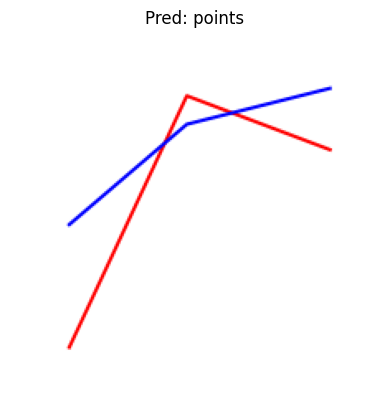

[INFO] Model loaded on cuda:0


0it [00:00, ?it/s]

Iter: 0 Loss: 0.2662 Val Loss: 2.5299


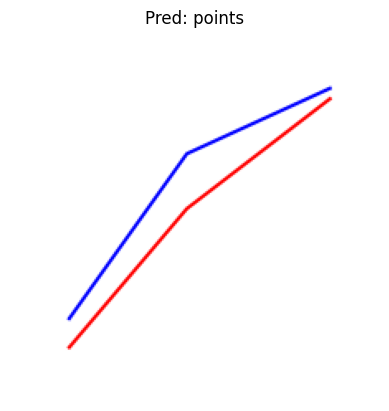

50it [00:38,  2.54it/s]

Iter: 50 Loss: 0.0867 Val Loss: 0.5560


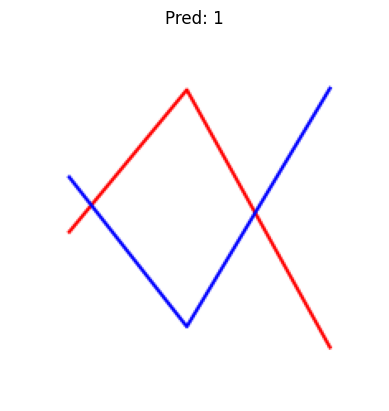

100it [01:17,  2.50it/s]

Iter: 100 Loss: 0.0568 Val Loss: 0.4565


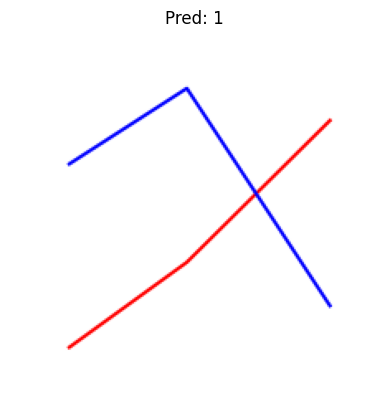

150it [01:56,  2.52it/s]

Iter: 150 Loss: 0.0820 Val Loss: 0.5306


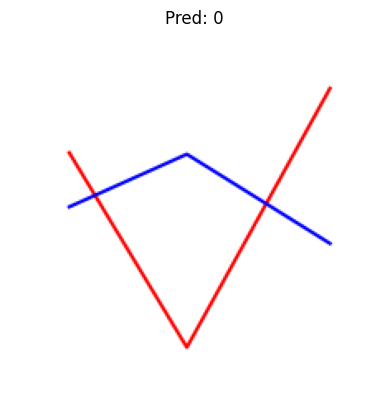

200it [02:35,  2.49it/s]

Iter: 200 Loss: 0.0592 Val Loss: 0.3398


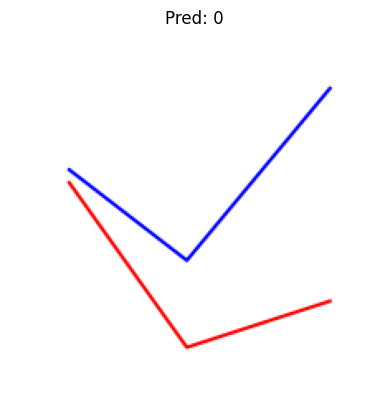

250it [03:14,  2.53it/s]

Iter: 250 Loss: 0.0245 Val Loss: 0.3446


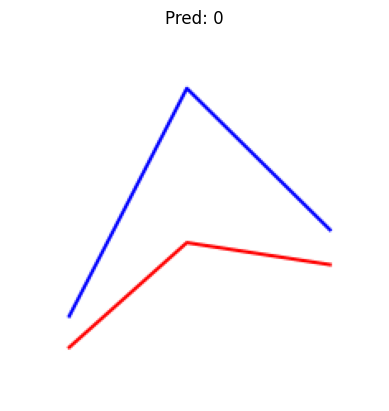

300it [03:53,  2.52it/s]

Iter: 300 Loss: 0.0231 Val Loss: 0.2296


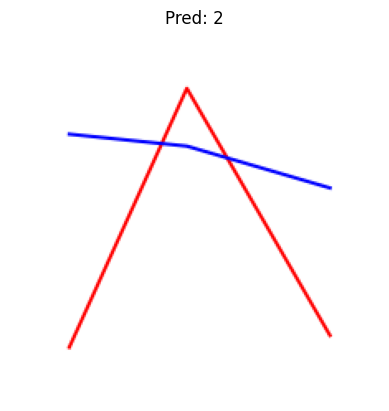

350it [04:32,  2.51it/s]

Iter: 350 Loss: 0.0800 Val Loss: 0.4465


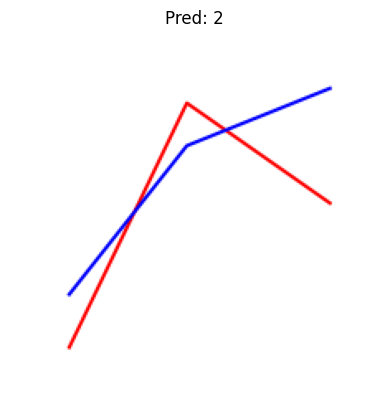

400it [05:11,  2.50it/s]

Iter: 400 Loss: 0.0216 Val Loss: 0.1382


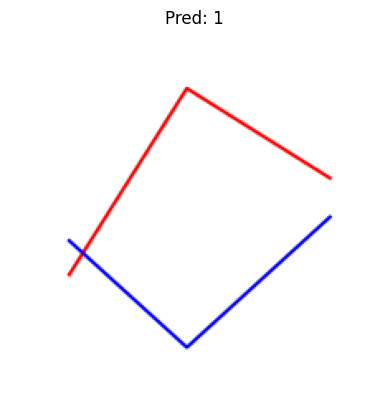

450it [05:50,  2.52it/s]

Iter: 450 Loss: 0.0433 Val Loss: 0.2467


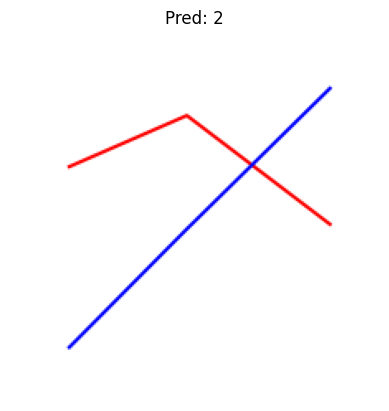

500it [06:29,  2.53it/s]

Iter: 500 Loss: 0.0024 Val Loss: 0.1484


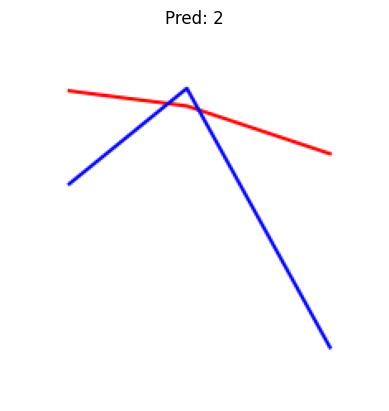

550it [07:08,  2.51it/s]

Iter: 550 Loss: 0.0123 Val Loss: 0.1567


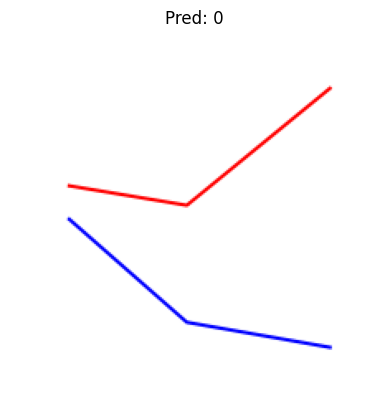

600it [07:47,  2.52it/s]

Iter: 600 Loss: 0.0022 Val Loss: 0.0870


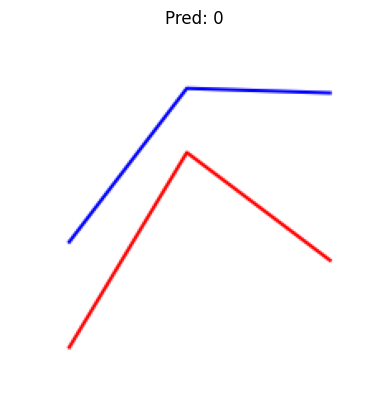

650it [08:26,  2.53it/s]

Iter: 650 Loss: 0.2225 Val Loss: 0.0949


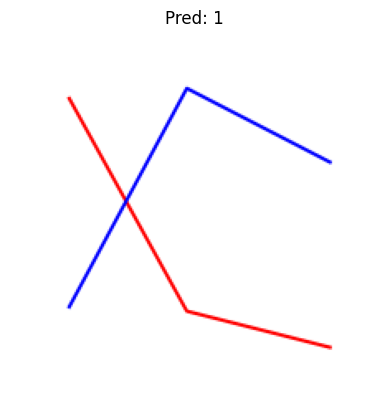

700it [09:05,  2.51it/s]

Iter: 700 Loss: 0.0209 Val Loss: 0.0888


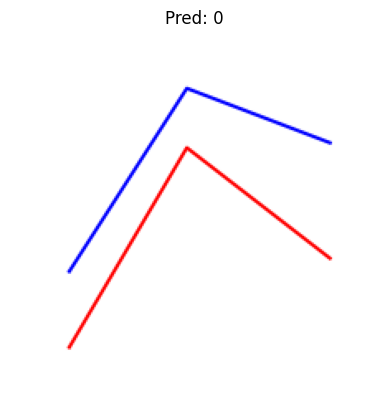

750it [09:44,  2.51it/s]

Iter: 750 Loss: 0.0004 Val Loss: 0.1187


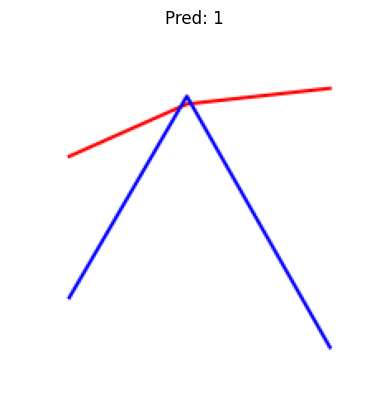

800it [10:23,  2.51it/s]

Iter: 800 Loss: 0.0504 Val Loss: 0.1193


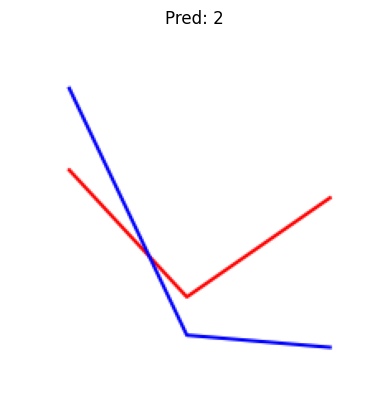

850it [11:02,  2.51it/s]

Iter: 850 Loss: 0.0018 Val Loss: 0.0756


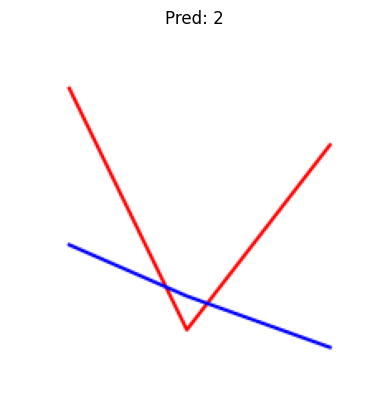

900it [11:41,  2.50it/s]

Iter: 900 Loss: 0.0008 Val Loss: 0.0820


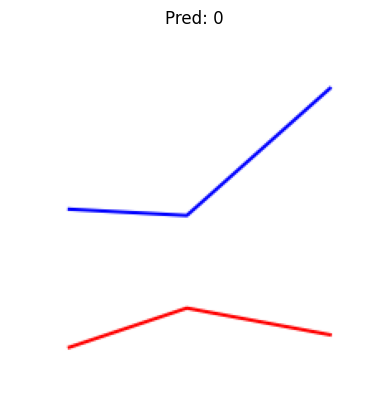

950it [12:20,  2.51it/s]

Iter: 950 Loss: 0.0017 Val Loss: 0.0836


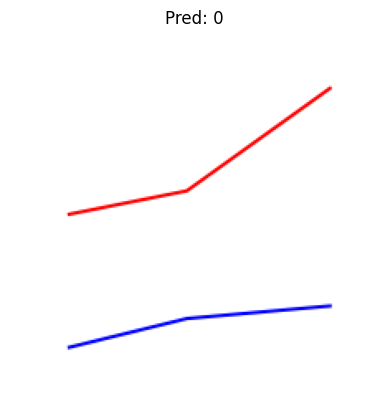

1000it [12:59,  2.46it/s]

Iter: 1000 Loss: 0.0602 Val Loss: 0.0900


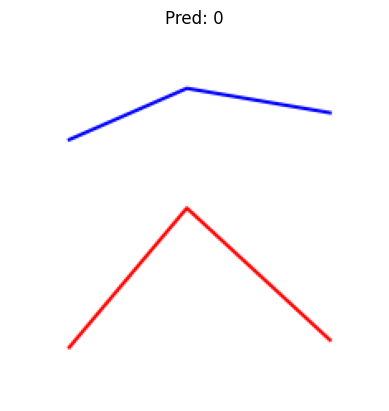

1050it [13:38,  2.52it/s]

Iter: 1050 Loss: 0.0008 Val Loss: 0.0881


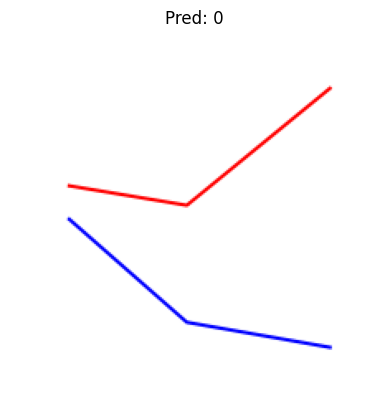

1100it [14:17,  2.51it/s]

Iter: 1100 Loss: 0.0338 Val Loss: 0.0926


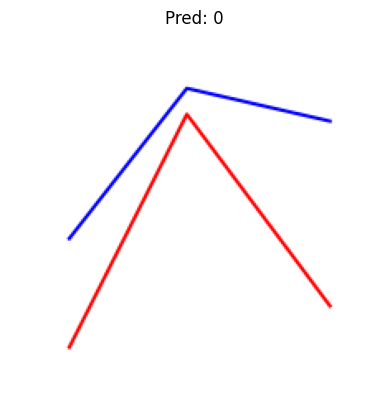

1150it [14:56,  2.49it/s]

Iter: 1150 Loss: 0.0002 Val Loss: 0.0786


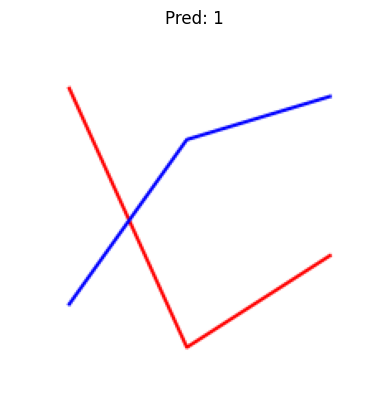

1200it [15:35,  2.51it/s]

Iter: 1200 Loss: 0.0001 Val Loss: 0.0828


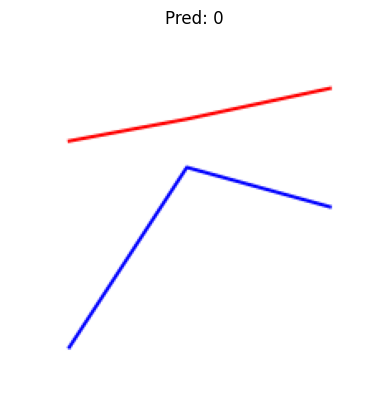

1250it [16:14,  2.51it/s]

Iter: 1250 Loss: 0.0019 Val Loss: 0.1072


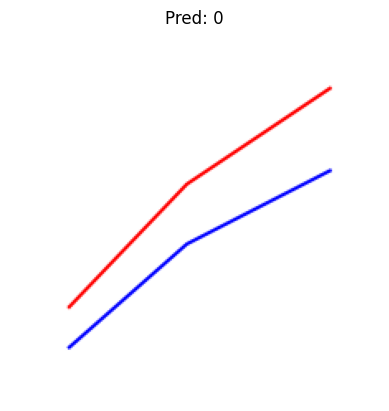

1300it [16:53,  2.51it/s]

Iter: 1300 Loss: 0.0015 Val Loss: 0.0940


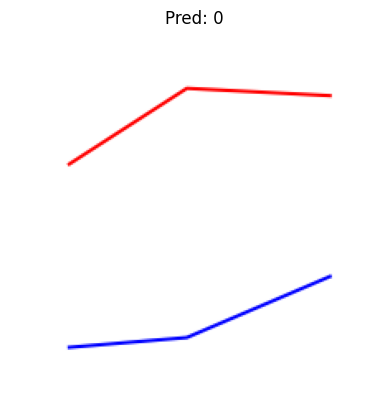

1350it [17:32,  2.52it/s]

Iter: 1350 Loss: 0.0358 Val Loss: 0.0876


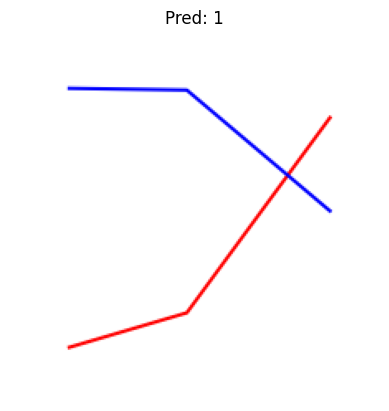

1400it [18:12,  2.50it/s]

Iter: 1400 Loss: 0.0016 Val Loss: 0.0869


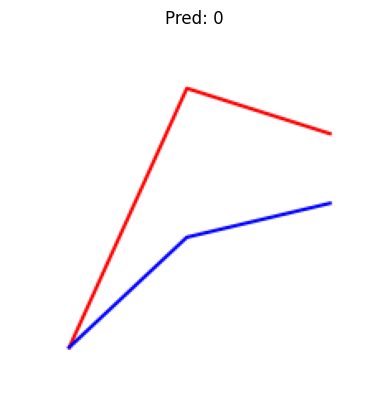

1450it [18:51,  2.50it/s]

Iter: 1450 Loss: 0.0186 Val Loss: 0.0764


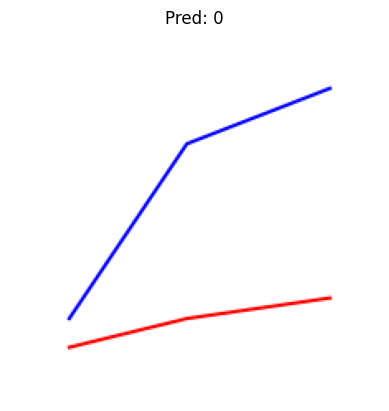

1500it [19:30,  1.28it/s]


In [4]:
main(ckpt_id="google/paligemma2-3b-pt-224", dataset_folder="ariG23498/intersection-dataset")